## Load the data

In [15]:
import datasets
import torch
from math import sqrt

device = 'cuda'
dataset = 'mnist'

# Training parameters
n_latent = 50
n_bins = 50
batch_size = 50
num_epochs = 100
learning_rate = 1e-4

# Inference parameters
n_samples = 10
plot_interval = 5

# Download and load the data if needed (MNIST or fashion-MNIST)
train_x, train_labels, test_x, test_labels = datasets.load_mnist() if dataset == 'mnist' else datasets.load_fashion_mnist()

# Normalize the data to be between 0 and 1
train_x = datasets.normalize_min_max(train_x, 0., 1.)
test_x = datasets.normalize_min_max(test_x, 0., 1.)

# Split off the validation set
valid_x = train_x[-10000:, :]
train_x = train_x[:-10000, :]
valid_labels = train_labels[-10000:]
train_labels = train_labels[:-10000]

# Generate torch tensors from the data
train_x = torch.tensor(train_x).to(device)
test_x = torch.tensor(test_x).to(device)
train_N, train_D = train_x.shape

# Determine the number of pixels on one side of the image
img_size = int(sqrt(train_D))

# Determine the number of classes
n_classes = len(set(train_labels))

## Base Encoder

In [16]:
from torch.nn import Conv2d, BatchNorm2d, ELU, Module, ModuleList

class BaseEncoder(Module):
    def __init__(self, n_latent: int, in_channels: int, n_conv_blocks: int, n_filters: int):
        super(BaseEncoder, self).__init__()
        self.n_latent = n_latent
        conv_head = []
        for i in range(n_conv_blocks):
            conv_head.append(Conv2d(in_channels, n_filters, kernel_size=3, stride=2, padding=1))
            conv_head.append(BatchNorm2d(n_filters))
            conv_head.append(ELU(inplace=True))
            in_channels = n_filters
            n_filters *= 2
        self.conv_head = ModuleList(conv_head)

    def to_latent(self, flattened):
        raise NotImplementedError

    def forward(self, input_x):
        res = input_x
        for layer in self.conv_head:
            res = layer(res)
        res = res.flatten(1)
        return self.to_latent(res)

## Base Decoder

In [17]:
from torch import relu
from torch.nn import Linear, BatchNorm2d, ConvTranspose2d

class BaseDecoder(Module):
    def __init__(self, n_latent: int, n_deconv_blocks: int, in_channels: int, n_fc: int):
        super(BaseDecoder, self).__init__()
        self.in_channels = in_channels
        self.filter_size = int(sqrt(n_fc / in_channels))
        self.dense = Linear(n_latent, n_fc)

        de_conv_head = []
        for i in range(n_deconv_blocks):
            # Don't use output padding for the first block
            out_padding = 0 if i == 0 else 1
            # The last block should output a single channel
            out_channels = 1 if i == n_deconv_blocks - 1 else in_channels // 2
            de_conv_head.append(ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1,
                                                output_padding=out_padding))
            de_conv_head.append(BatchNorm2d(out_channels))
            de_conv_head.append(ELU(inplace=True))
            in_channels = out_channels
        self.de_conv_head = ModuleList(de_conv_head)

    def output(self, deconvoluted):
        raise NotImplementedError

    def forward(self, z):
        # First run the latent vector through a dense layer
        res = relu(self.dense(z))
        # Create a suitable shape for the de-convolution
        res = res.reshape(-1, self.in_channels, self.filter_size, self.filter_size)
        for layer in self.de_conv_head:
            res = layer(res)
        res = res.flatten(1)
        return self.output(res)

## Base VAE

In [18]:
class VAE:
    def __init__(self, encoder: Module, decoder: Module, device: str):
        self.encoder = encoder.to(device)
        self.decoder = decoder.to(device)
        self.device = device

    def reparameterize(self, *args):
        raise NotImplementedError

    def forward(self, x):
        raise NotImplementedError

    def loss(self, x):
        raise NotImplementedError

    def sample(self, n_samples: int):
        raise NotImplementedError

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

# Task 1a

## Build a Gaussian VAE

In [19]:
class GaussianEncoder(BaseEncoder):
    def __init__(self, n_latent: int, in_channels=1, n_conv_blocks=3, n_filters=32, n_fc=2048):
        super(GaussianEncoder, self).__init__(n_latent, in_channels, n_conv_blocks, n_filters)

        # Mean and variance layers
        self.mu = Linear(n_fc, n_latent)
        self.var = Linear(n_fc, n_latent)
        self.var_act = Softplus()

    def to_latent(self, flattened):
        mu = self.mu(flattened)
        var = self.var_act(self.var(flattened))
        return mu, var

In [20]:
from torch.nn import Softplus

class GaussianDecoder(BaseDecoder):
    def __init__(self, n_pixels: int, n_latent: int, n_deconv_blocks=3, in_channels=128, n_fc=2048, var=0.05):
        super(GaussianDecoder, self).__init__(n_latent, n_deconv_blocks, in_channels, n_fc)
        self.n_latent = n_latent
        self.in_channels = in_channels
        self.filter_size = int(sqrt(n_fc / in_channels))
        self.var = var

        # Generate the output layer
        self.mu = Linear(n_pixels, n_pixels)

    def output(self, deconvoluted):
        return self.mu(deconvoluted)

In [21]:
class GaussianVAE(VAE):
    def __init__(self, n_latent: int, n_pixels: int, device: str):
        super().__init__(GaussianEncoder(n_latent), GaussianDecoder(n_pixels, n_latent), device)
        self.n_latent = n_latent

    def reparameterize(self, mu, var):
        return mu + torch.sqrt(var) * torch.randn(var.shape, device=self.device)

    def forward(self, x):
        mu_z, var_z = self.encode(x)
        z = self.reparameterize(mu_z, var_z)
        return self.decode(z)

    def loss(self, x):
        mu_z, var_z = self.encode(x)
        z = self.reparameterize(mu_z, var_z)
        x_decoded = self.decode(z)

        recon = x_decoded + sqrt(self.decoder.var) * torch.randn(x.flatten(1).shape[1], device=self.device)
        mse = (recon - x.flatten(1))**2
        recon_loss = 0.5 * torch.sum(np.log(self.decoder.var * 2 * np.pi) + mse / self.decoder.var)

        kl_loss = torch.mean(0.5 * torch.sum(mu_z**2 + var_z**2 - torch.log(var_z**2) - 1, dim=1))
        return recon_loss + kl_loss

    def sample(self, n_samples: int):
        with torch.no_grad():
            z = torch.randn(n_samples, self.n_latent, device=self.device)
            x = self.decode(z)
            return x, z

In [200]:
def print_vae_params(vae: VAE):
    print(vae_gaussian.encoder)
    print(vae_gaussian.decoder)
    print(f'Number of encoder parameters: {sum(p.numel() for p in vae_gaussian.encoder.parameters())}')
    print(f'Number of decoder parameters: {sum(p.numel() for p in vae_gaussian.decoder.parameters())}')

In [29]:
vae_gaussian = GaussianVAE(n_latent, train_D, device)
print_vae_params(vae_gaussian)

GaussianEncoder(
  (conv_head): ModuleList(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ELU(alpha=1.0, inplace=True)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ELU(alpha=1.0, inplace=True)
  )
  (mu): Linear(in_features=2048, out_features=50, bias=True)
  (var): Linear(in_features=2048, out_features=50, bias=True)
  (var_act): Softplus(beta=1, threshold=20)
)
GaussianDecoder(
  (dense): Linear(in_features=50, out_features=2048, bias=True)
  (de_conv_head): ModuleList(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 

# Task 1b & 1c

## Generic VAE training method

In [190]:
def train_vae(vae: VAE, dist_type: str, stop_criterion: float):

    # Use Adam as the optimizer for both the encoder and decoder
    optimizer = torch.optim.Adam(list(vae.decoder.parameters()) + list(vae.encoder.parameters()), lr=learning_rate)

    loss_history = []
    pbar = tqdm(range(num_epochs))
    for epoch in pbar:
        # make batches of training indices
        shuffled_idx = torch.randperm(train_x.shape[0])
        idx_batches = shuffled_idx.split(batch_size)
        sum_loss = 0.0
        for batch_count, idx in enumerate(idx_batches):
            optimizer.zero_grad()
            batch_x = train_x[idx, :]
            input_x = batch_x.reshape(batch_size, img_size, img_size).unsqueeze(1)

            loss = vae.loss(input_x)
            loss.backward()
            optimizer.step()
            sum_loss += loss
        mean_loss = sum_loss / train_x.shape[0]
        pbar.set_postfix({'Loss': mean_loss})
        loss_history.append(mean_loss.cpu().detach().numpy())

        if mean_loss < stop_criterion:
            print(f'Training criterion ({stop_criterion}) reached at epoch {epoch}. Stopping training...')
            # Store the model weights
            pickle.dump(vae.encoder.state_dict(), open(f"models/{dist_type}/encoder.pkl", "wb"))
            pickle.dump(vae.decoder.state_dict(), open(f"models/{dist_type}/decoder.pkl", "wb"))
            break

## Train the Gaussian VAE

In [191]:
import numpy as np
from tqdm import tqdm
import pickle

dist_type = 'gaussian'
stop_criterion = 30

try:
    vae_gaussian.encoder.load_state_dict(pickle.load(open(f"models/{dist_type}/encoder.pkl", "rb")))
    vae_gaussian.decoder.load_state_dict(pickle.load(open(f"models/{dist_type}/decoder.pkl", "rb")))
except FileNotFoundError:
    print(f'Existing model not found. Training a new {dist_type} VAE...')
    train_vae(vae_gaussian, dist_type, stop_criterion)

Existing model not found. Training a new VAE...


  0%|                                                                                                                                                                                              | 0/100 [00:06<?, ?it/s, Loss=tensor(23.6672, device='cuda:0', grad_fn=<DivBackward0>)]

Training criterion (30) reached at epoch 0. Stopping training...


# Task 1d

## Generic method for plotting reconstructions and samples

In [283]:
from matplotlib import pyplot as plt
from PIL import Image
from itertools import chain

def plot_reconstruction(vae: VAE, dist_type: str, n_samples: int, samples = None, reconstruct=False):
    
    # Reconstruct the input images
    if reconstruct:
        samples = samples.reshape(n_samples, img_size, img_size)
        images = samples.unsqueeze(1)
        
        if dist_type == 'gaussian':
            x_decoded = vae.forward(images)
        elif dist_type == 'beta':
            alpha, beta = vae.forward(images)
            x_decoded = log_beta_pdf(samples.flatten(1), alpha, beta)
            x_decoded = torch.sigmoid(x_decoded)
        elif dist_type == 'bernoulli':
            x_decoded, _ = vae.forward(images)
            x_decoded = torch.bernoulli(x_decoded)
            samples = torch.bernoulli(samples)
        else:
            raise ValueError(f"Unknown distribution type: {dist_type}")
            
        x_decoded = x_decoded.reshape(n_samples, img_size, img_size).detach().cpu().numpy()
        
        images = images.squeeze().detach().cpu().numpy()
        plot_images = list(chain.from_iterable(zip(images, x_decoded)))
    else:
        samples, _ = vae.sample(n_samples)
        samples = samples.reshape(n_samples, img_size, img_size)
        plot_images = samples.detach().cpu().numpy()

    # Plot images
    height = samples.shape[1]
    width = samples.shape[2]

    num_columns = 8
    num_rows = len(plot_images) // num_columns
    frame = 2
    frame_gray_val = 1.0
    margin = 5
    margin_gray_val = 1.0

    img = margin_gray_val * np.ones((height * num_rows + (num_rows - 1) * margin, 
                                     width * num_columns + (num_columns - 1) * margin))
    counter = 0
    for h in range(num_rows):
        for w in range(num_columns):
            img[h * (height + margin) : h * (height + margin) + height, 
                w * (width + margin) : w * (width + margin) + width] = plot_images[counter]
            counter += 1

    framed_img = frame_gray_val * np.ones((img.shape[0] + 2*frame, img.shape[1] + 2*frame))
    framed_img[frame:(frame+img.shape[0]), frame:(frame+img.shape[1])] = img
    
    plt.imshow(framed_img)

## Plot the Gaussian VAE reconstructions

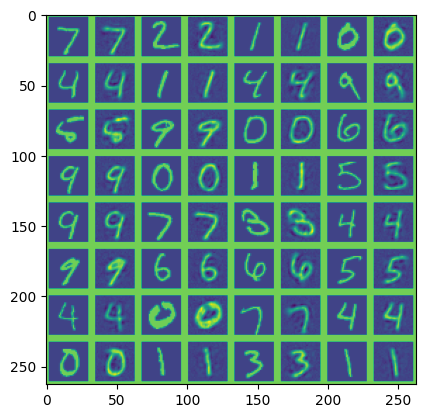

In [287]:
dist_type = 'gaussian'
n_samples = 32
test_samples = test_x[0:n_samples :]

# Plot the reconstruction of test images
plot_reconstruction(vae_gaussian, dist_type, n_samples, test_samples, reconstruct=True)

## Plot the Gaussian VAE samples

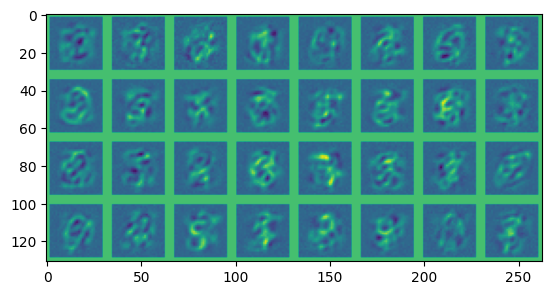

In [288]:
# Generate new images by sampling from the latent space
plot_reconstruction(vae_gaussian, dist_type, n_samples)

# Task 2a

# Task 2b

## Build a Beta VAE

The Encoder remains the same.  
The Decoder now outputs the Beta Distribution parameters (alpha and beta) for each pixel.  
We use the built-in torch Beta distribution for sampling.

In [205]:
class BetaDecoder(BaseDecoder):
    def __init__(self, n_pixels: int, n_latent: int, n_deconv_blocks=3, in_channels=128, n_fc=2048):
        super(BetaDecoder, self).__init__(n_latent, n_deconv_blocks, in_channels, n_fc)
        self.n_pixels = n_pixels
        self.n_latent = n_latent

        self.alpha = Linear(n_pixels, n_pixels)
        self.beta = Linear(n_pixels, n_pixels)
        self.act = Softplus()

    def output(self, deconvoluted):
        # Output the parameters of the Beta Distribution
        alpha = self.act(self.alpha(deconvoluted))
        beta = self.act(self.beta(deconvoluted))
        return alpha, beta

In [206]:
from torch.distributions import Beta

class BetaVAE(VAE):
    def __init__(self, n_latent: int, n_pixels: int, device: str):
        super().__init__(GaussianEncoder(n_latent), BetaDecoder(n_pixels, n_latent), device)
        self.n_latent = n_latent

    def reparameterize(self, mu, var):
        return mu + torch.sqrt(var) * torch.randn(var.shape, device=self.device)

    def forward(self, x):
        mu, var = self.encode(x)
        z = self.reparameterize(mu, var)
        return self.decode(z)

    def loss(self, x):
        mu, var = self.encode(x)
        z = self.reparameterize(mu, var)
        alpha, beta = self.decode(z)

        recon_loss = torch.mean(log_beta_pdf(x.flatten(1), alpha, beta))
        kl_loss = torch.mean(0.5 * torch.sum(mu**2 + var**2 - torch.log(var**2) - 1, dim=1))
        return recon_loss + kl_loss

    def sample(self, n_samples: int):
        with torch.no_grad():
            z = torch.randn(n_samples, self.n_latent, device=self.device)
            alpha, beta = self.decode(z)
            beta_dist = Beta(alpha, beta)
            x = beta_dist.sample()
            return x, z

In [207]:
vae_beta = BetaVAE(n_latent, train_D, device)
print_vae_params(vae_beta)

GaussianEncoder(
  (conv_head): ModuleList(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ELU(alpha=1.0, inplace=True)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ELU(alpha=1.0, inplace=True)
  )
  (mu): Linear(in_features=2048, out_features=50, bias=True)
  (var): Linear(in_features=2048, out_features=50, bias=True)
  (var_act): Softplus(beta=1, threshold=20)
)
GaussianDecoder(
  (dense): Linear(in_features=50, out_features=2048, bias=True)
  (de_conv_head): ModuleList(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 

## Train the Beta VAE and plot the results

In [212]:
def log_beta_pdf(x, alpha, beta, eps=1e-8):
    """
    Calculate the log pdf of a beta distribution
    :param batch_x: batch of samples from the beta distribution
    :param alpha: alpha parameter of the beta distribution
    :param beta: beta parameter of the beta distribution
    :param eps: epsilon to avoid numerical issues when taking logarithms
    :return: log pdf of the beta distribution
    """
    return -(torch.lgamma(alpha + beta) - torch.lgamma(alpha) - torch.lgamma(beta) + 
             (alpha - 1) * torch.log(x + eps) + (beta - 1) * torch.log(1 - x + eps))

In [242]:
dist_type = 'beta'
stop_criterion = -0.235

try:
    vae_beta.encoder.load_state_dict(pickle.load(open(f"models/{dist_type}/encoder.pkl", "rb")))
    vae_beta.decoder.load_state_dict(pickle.load(open(f"models/{dist_type}/decoder.pkl", "rb")))
except FileNotFoundError:
    print(f'Existing model not found. Training a new {dist_type} VAE...')
    train_vae(vae_beta, dist_type, stop_criterion)

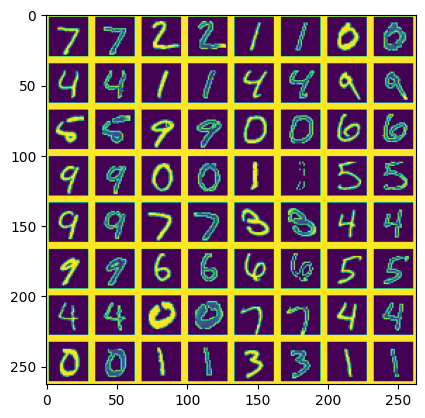

In [252]:
plot_reconstruction(vae_beta, 'beta', n_samples, test_samples, reconstruct=True)

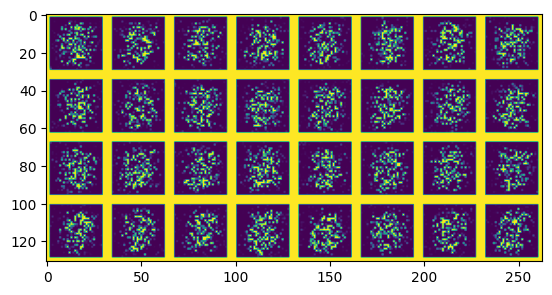

In [254]:
# Generate new images by sampling from the latent space
plot_reconstruction(vae_beta, dist_type, n_samples)

# Task 2c

Picked a number of bins k=51 which divides with the number of pixels, so each bin would have an equal number of pixels.

# Task 2d

In [258]:
class BernoulliEncoder(BaseEncoder):
    def __init__(self, n_latent: int, in_channels=1, n_conv_blocks=3, n_filters=32, n_fc=2048):
        super(BernoulliEncoder, self).__init__(n_latent, in_channels, n_conv_blocks, n_filters)
        self.dense = Linear(n_fc, n_latent)

    def to_latent(self, convoluted):
        return self.dense(convoluted)

In [262]:
from torch.nn import Sigmoid

class BernoulliDecoder(BaseDecoder):
    def __init__(self, n_pixels: int, n_latent: int, n_deconv_blocks=3, in_channels=128, n_fc=2048, var=0.05):
        super(BernoulliDecoder, self).__init__(n_latent, n_deconv_blocks, in_channels, n_fc)
        self.n_latent = n_latent
        self.out = Linear(n_pixels, n_pixels)
        self.out_act = Sigmoid()

    def output(self, deconvoluted):
        return self.out_act(self.out(deconvoluted))

In [271]:
def binomial_kl(z: torch.Tensor, device: str) -> torch.Tensor:
    """
    Computes the KL divergence between binomial distributions.
    :param z: A tensor of shape (batch_size, n_latent) containing the logits of the binomial
    :param device: cpu/cuda
    :return:
    """

    p = torch.distributions.Bernoulli(torch.full(z.shape, 0.5, device=device))
    q = torch.distributions.Bernoulli(logits=z)

    new_z = q.sample()

    log_qzx = q.log_prob(new_z)
    log_pz = p.log_prob(new_z)

    KL = (log_qzx - log_pz)
    KL = torch.mean(torch.sum(KL, dim=1))

    return KL

In [272]:
from torch.nn.functional import gumbel_softmax, binary_cross_entropy

class BernoulliVAE(VAE):
    def __init__(self, n_latent: int, n_pixels: int, device: str):
        super().__init__(BernoulliEncoder(n_latent), BernoulliDecoder(n_pixels, n_latent), device)
        self.n_latent = n_latent

    def reparameterize(self, z):
        return gumbel_softmax(z).flatten(1)

    def forward(self, x):
        x_binary = torch.bernoulli(x)
        z = self.encode(x_binary)
        z = self.reparameterize(z)
        return self.decode(z), z

    def loss(self, x):
        x_decoded, z = self.forward(x)
        entropy_loss = binary_cross_entropy(x_decoded, x.flatten(1))
        kl_loss = binomial_kl(z, self.device)
        # loss = entropy_loss + kl_loss
        return entropy_loss

    def sample(self, n_samples: int):
        with torch.no_grad():
            z = torch.randn(n_samples, self.n_latent, device=self.device)
            z = gumbel_softmax(z).flatten(1)
            x = self.decode(z)
            x = torch.bernoulli(x)
            return x, z

In [273]:
vae_bernoulli = BernoulliVAE(n_latent, train_D, device)

In [289]:
dist_type = 'bernoulli'
stop_criterion = 0.003

try:
    vae_bernoulli.encoder.load_state_dict(pickle.load(open(f"models/{dist_type}/encoder.pkl", "rb")))
    vae_bernoulli.decoder.load_state_dict(pickle.load(open(f"models/{dist_type}/decoder.pkl", "rb")))
except FileNotFoundError:
    print(f'Existing model not found. Training a new {dist_type} VAE...')
    train_vae(vae_bernoulli, dist_type, stop_criterion)

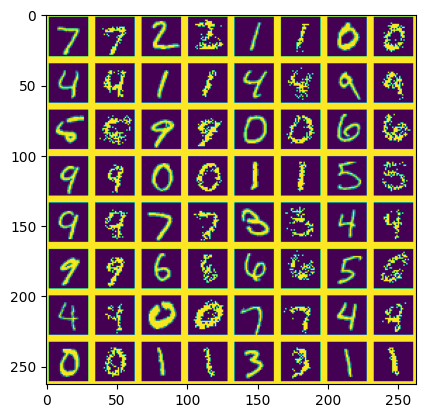

In [290]:
plot_reconstruction(vae_bernoulli, dist_type, n_samples, test_samples, reconstruct=True)

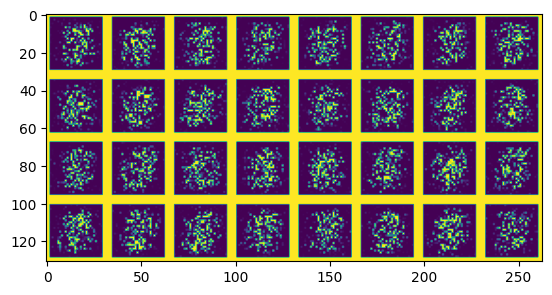

In [291]:
# Generate new images by sampling from the latent space
plot_reconstruction(vae_beta, dist_type, n_samples)

# Task 2e